<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/universal_trading_pipeline_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import time, os, tensorflow as tf
import matplotlib.pyplot as plt


In [32]:
# TensorFlow GPU Memory Configuration
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow GPU memory growth enabled")
    except RuntimeError as e:
        print(f"TensorFlow GPU memory issue: {e}")

os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'

In [33]:
# CONFIG
CONFIG = {
    'symbols': ['AAPL', 'TSLA'],
    'period': '720d',
    'interval': '1h',
    'lookahead': 10,
    'threshold_factor': 2,
    'features': ['SMA_20', 'STD_20', 'Upper_Band', 'Lower_Band', 'Stoch', 'volatility'],
    'target': 'Target'
}

In [34]:
# Data Download Function
def download_stock_data(ticker, period="720d", interval="1h", max_retries=5):
    for attempt in range(1, max_retries + 1):
        try:
            print(f"Attempt {attempt}: Downloading {ticker} stock data...")
            df_live = yf.download(ticker, period=period, interval=interval)
            if not df_live.empty:
                print("Successfully downloaded stock data for", ticker)
                df_live.reset_index(inplace=True)
                df_live['Symbol'] = ticker
                return df_live
            raise ValueError("Downloaded data is empty. Retrying...")
        except Exception as e:
            print(f"Error: {e}. Retrying in {attempt * 5} seconds...")
            time.sleep(attempt * 5)
    print("Failed to download stock data after multiple attempts for", ticker)
    return None


In [35]:
# Feature Engineering (with MultiIndex Fix)
def compute_technical_indicators(df):
    df = df.copy()

    # Fix: Handle MultiIndex columns and duplicates
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df.loc[:, ~df.columns.duplicated()]

    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['STD_20'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['SMA_20'] + 2 * df['STD_20']
    df['Lower_Band'] = df['SMA_20'] - 2 * df['STD_20']

    df['Lowest_Low'] = df['Low'].rolling(window=14).min()
    df['Highest_High'] = df['High'].rolling(window=14).max()

    close = df['Close'].astype(float)
    lowest_low = df['Lowest_Low'].astype(float)
    highest_high = df['Highest_High'].astype(float)

    denominator = (highest_high - lowest_low).replace(0, np.nan)
    stoch = ((close - lowest_low) / denominator) * 100

    print("DEBUG: Stoch shape =", stoch.shape)  # Should be (n,)
    df['Stoch'] = stoch.astype(float)

    df['volatility'] = df['Close'].pct_change().rolling(20).std()
    df.dropna(inplace=True)

    return df

In [36]:
# Label Generator
def generate_trade_labels(df, lookahead=10, threshold_factor=2):
    df['Future_Close'] = df['Close'].shift(-lookahead)
    df['Price_Change'] = (df['Future_Close'] - df['Close']) / df['Close']
    df['Target'] = np.where(df['Price_Change'] > 0.03, 1, 0)

    buy_threshold = df['volatility'] * threshold_factor
    sell_threshold = -df['volatility'] * threshold_factor
    df['Dynamic_Label'] = np.where(df['Price_Change'] > buy_threshold, 1,
                            np.where(df['Price_Change'] < sell_threshold, -1, 0))

    df.dropna(inplace=True)
    return df

In [37]:
# Simple Backtest
def simple_backtest(df, target_col='Target'):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df[target_col].shift(1) * df['Return']
    df['Equity_Curve'] = (1 + df['Strategy_Return']).cumprod()
    return df

In [48]:
def run_universal_framework(config):
    all_results = {}

    for symbol in config['symbols']:
        print(f"\nProcessing {symbol}")
        df = download_stock_data(symbol, config['period'], config['interval'])

        if df is None:
            print(f"Skipping {symbol} due to download error.")
            continue

        df = compute_technical_indicators(df)
        df = generate_trade_labels(df, config['lookahead'], config['threshold_factor'])

        df = simple_backtest(df, config['target'])
        all_results[symbol] = df

        # Save to CSV in /content/ or your preferred path
        df.to_csv(f"/content/{symbol}_universal_features.csv", index=False)
        print(f"Saved: {symbol}_universal_features.csv")


        # Optional: Plot
        plt.figure(figsize=(10, 4))
        plt.plot(df['Datetime'], df['Equity_Curve'], label='Equity Curve')
        plt.title(f"{symbol} Strategy Performance")
        plt.xlabel("Date")
        plt.ylabel("Equity")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return all_results



Processing AAPL
Attempt 1: Downloading AAPL stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for AAPL
DEBUG: Stoch shape = (5016,)
Saved: AAPL_universal_features.csv


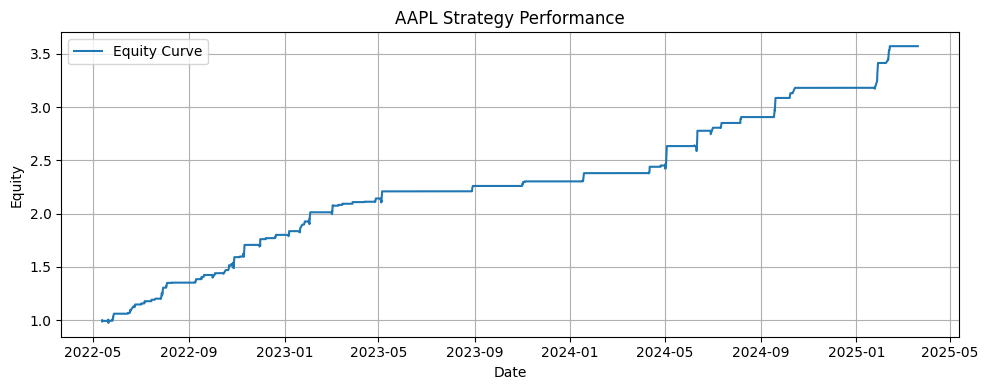


Processing TSLA
Attempt 1: Downloading TSLA stock data...


[*********************100%***********************]  1 of 1 completed


Successfully downloaded stock data for TSLA
DEBUG: Stoch shape = (5016,)
Saved: TSLA_universal_features.csv


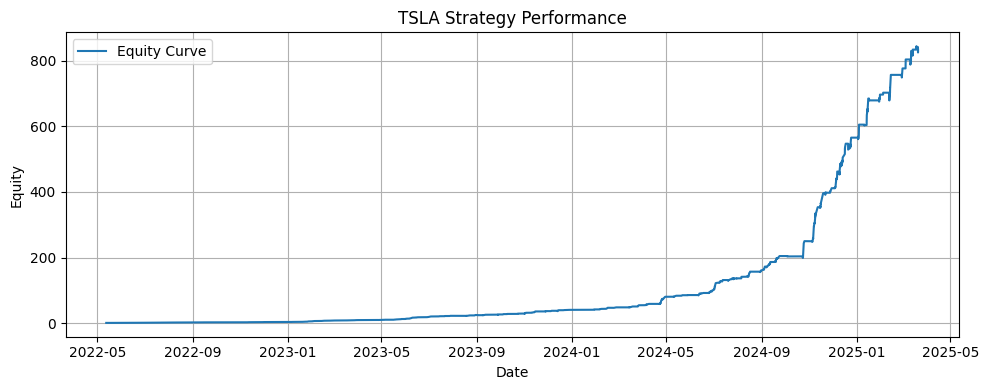

In [49]:
# Run the Framework
if __name__ == "__main__":
    results = run_universal_framework(CONFIG)

In [50]:
import os
os.listdir('/content')


['.config',
 'TSLA_features.csv',
 'TSLA_universal_features.csv',
 'drive',
 'AAPL_features.csv',
 'AAPL_universal_features.csv',
 'sample_data']